## PINN Shrodinger code

In [2]:
pip install tensorflow numpy matplotlib scipy

  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/385.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/385.0 MB 5.6 MB/s eta 0:01:09
   ---------------------------------------- 2.1/385.0 MB 5.9 MB/s eta 0:01:06
   ---------------------------------------- 3.4/385.0 MB 6.1 MB/s eta 0:01:03
   ---------------------------------------- 4.2/385.0 MB 

### Вызываем все библиотеки которые нужны для модели

In [21]:
import sys
sys.path.insert(0, '../../Utilities/')

from scipy.interpolate import griddata
import tensorflow as tf #для создания и обучения нейронной сети.
from tensorflow import keras
import numpy as np  #для работы с массивами данных.
import scipy.io# для загрузки данных из файлов MATLAB.
import time
import matplotlib.pyplot as plt # для визуализации
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata #для интерполяции данных

### Класс PhysicsInformedNN реализует физически информированную нейронную сеть (PINN) для решения дифференциальных уравнений. Он обучает нейронную сеть с учетом как данных, так и физических законов, выраженных в виде остатков от уравнений. Эта модель комбинирует начальные условия и законы физики для предсказания решений уравнений, таких как уравнения Навье-Стокса, Шредингера и др.

In [6]:
class PhysicsInformedNN:
    def __init__(self, x0, u0, v0, tb, X_f, layers, lb, ub):
        # Преобразование начальных условий x0, u0, v0 и tb в тензоры
        self.x0 = tf.convert_to_tensor(np.reshape(x0, (-1, 1)), dtype=tf.float32)  # Начальные условия
        self.u0 = tf.convert_to_tensor(np.reshape(u0, (-1, 1)), dtype=tf.float32)
        self.v0 = tf.convert_to_tensor(np.reshape(v0, (-1, 1)), dtype=tf.float32)
        self.tb = tf.convert_to_tensor(np.reshape(tb, (-1, 1)), dtype=tf.float32)  # Временные границы

        # Преобразование точек для физического остатка в тензор с float32 типом
        self.X_f = tf.convert_to_tensor(X_f, dtype=tf.float32)  # Для расчета физического остатка
        
        # Установка нижних и верхних границ области
        self.lb = np.array(lb)  # Нижние и верхние границы области
        self.ub = np.array(ub)

        # Определение структуры слоев нейронной сети
        self.layers = layers

        # Инициализация модели
        self.model = self.initialize_model()
    
    def initialize_model(self):
        # Создание последовательной модели нейронной сети
        model = keras.Sequential()

        # Добавление входного слоя, который принимает на вход x и t
        model.add(keras.layers.Input(shape=(2,)))  # Входная форма (x, t)

        # Добавление скрытых слоев с активацией 'tanh'
        for neurons in self.layers[1:-1]:
            model.add(keras.layers.Dense(neurons, activation='tanh'))

        # Добавление выходного слоя, который предсказывает значения u и v
        model.add(keras.layers.Dense(2))  # Выход u и v
        
        return model

    def net_f_uv(self, x, t):
        # Определение функции для вычисления физического остатка
        with tf.GradientTape(persistent=True) as tape:
            # Установка слежения за градиентами по переменным x и t
            tape.watch(x)
            tape.watch(t)

            # Объединение x и t в один тензор X
            X = tf.concat([x, t], axis=1)

            # Пропуск X через модель, чтобы получить предсказания u и v
            uv = self.model(X)
            u = uv[:, 0:1]
            v = uv[:, 1:2]

            # Вычисление первых производных u_x и v_x
            u_x = tape.gradient(u, x)
            v_x = tape.gradient(v, x)

            # Вычисление вторых производных u_xx и v_xx
            u_xx = tape.gradient(u_x, x)
            v_xx = tape.gradient(v_x, x)

            # Вычисление производных по времени u_t и v_t
            u_t = tape.gradient(u, t)
            v_t = tape.gradient(v, t)

        # Удаление GradientTape, чтобы избежать утечек памяти
        del tape

        # Вычисление физических остатков f_u и f_v на основе уравнений
        f_u = u_t + 0.5 * v_xx + (u**2 + v**2) * v
        f_v = v_t - 0.5 * u_xx - (u**2 + v**2) * u

        return f_u, f_v

    def data_loss(self):
        # Вычисление ошибки данных на основе начальных условий
        x0_concat = tf.concat([self.x0, tf.zeros_like(self.x0)], axis=1)
        u0_pred = self.model(x0_concat)[:, 0:1]
        v0_pred = self.model(x0_concat)[:, 1:2]
        return tf.reduce_mean(tf.square(self.u0 - u0_pred)) + tf.reduce_mean(tf.square(self.v0 - v0_pred))
        # Эта строка вычисляет среднюю квадратичную ошибку (MSE) между предсказанными значениями 
        # 𝑢 и 𝑣 истинными начальными условиями 𝑢0 и 𝑣0. Это помогает оценить, 
        # насколько хорошо модель предсказывает начальные условия.
        
    def physics_loss(self):
        # Вычисление физического остатка на всех точках
        f_u, f_v = self.net_f_uv(self.X_f[:, 0:1], self.X_f[:, 1:2])  # Разделение X_f на x и t
        return tf.reduce_mean(tf.square(f_u)) + tf.reduce_mean(tf.square(f_v))

    def total_loss(self):
        # Общая ошибка как сумма ошибки данных и физического остатка
        return self.data_loss() + self.physics_loss()

    def train(self, nIter):
        # Оптимизатор Adam с заданным шагом обучения
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        
        for it in range(nIter):
            # Открытие GradientTape для вычисления градиентов
            with tf.GradientTape() as tape:
                # Вычисление общей ошибки
                loss_value = self.total_loss()

            # Вычисление градиентов по всем обучаемым параметрам модели
            grads = tape.gradient(loss_value, self.model.trainable_variables)
            #tape.gradient вычисляет градиенты ошибки по отношению к обучаемым переменным модели (веса и смещения).

            # Применение градиентов для обновления параметров модели
            optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
            # Функция zip объединяет градиенты и переменные модели в пары.
            
            if it % 100 == 0:
                print(f"Iteration {it}, Loss: {loss_value.numpy()}")

    def predict(self, x):
        # Преобразование входных данных x в тензор и предсказание значений u и v
        x = tf.convert_to_tensor(np.reshape(x, (-1, x.shape[-1])), dtype=tf.float32)
        # -1 вычиляет рамероность автоматический 
        # x.shape[-1]здесь нам возврашает послед размер массива например [10;3]то получаем 3
        
        uv_pred = self.model(x)
        u_pred = uv_pred[:, 0:1]
        v_pred = uv_pred[:, 1:2]

        return u_pred, v_pred



In [7]:
# Параметры модели
noise = 0.0        
lb = np.array([-5.0, 0.0])  # Нижняя граница области
ub = np.array([5.0, np.pi/2])  # Верхняя граница области

N0 = 150  # Количество начальных точек
N_b = 50  # Количество точек на границах
N_f = 20000  # Количество внутренних точек
layers = [2, 100, 100, 100, 100, 2]  # Структура сети: число нейронов в каждом слое


In [11]:
data = scipy.io.loadmat('NLS.mat')
t = data['tt'].flatten()[:, None]  # Временные шаги
x = data['x'].flatten()[:201, None]  # Пространственные координаты
Exact = data['uu']  # Истинные значения комплексного решения
Exact_u = np.real(Exact)  # Действительная часть
Exact_v = np.imag(Exact)  # Мнимая часть
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)  # Амплитуда волны


In [12]:
# Создание сетки для пространственно-временных данных
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))  # Объединение X и T в одну матрицу
u_star = Exact_u.T.flatten()[:, None]  # Истинные значения u
v_star = Exact_v.T.flatten()[:, None]  # Истинные значения v
h_star = Exact_h.T.flatten()[:, None]  # Истинные значения амплитуды

In [15]:
# Случайный выбор начальных условий
idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x, :]
u0 = Exact_u[idx_x, 0:1]
v0 = Exact_v[idx_x, 0:1]

# Случайный выбор временных границ
idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t, :]


In [16]:
# Случайный выбор начальных условий помогает избежать переобучения модели. 
# В реальных задачах часто невозможно использовать все данные из-за ограничений по 
# времени или ресурсам, поэтому выбирается случайное подмножество, что позволяет модели 
# обучаться на различных поднаборах данных и лучше обобщать результаты.


# Создание точек для обучения в пределах области
X_f = lb + (ub - lb) * np.random.uniform(0, 1, (N_f, 2))  # Использование np.random.uniform вместо lhs

# Инициализация и обучение модели
model = PhysicsInformedNN(x0, u0, v0, tb, X_f, layers, lb, ub)
start_time = time.time()
model.train(20)  # Обучение модели на 7000 итераций
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))  # Вывод времени обучения

# Предсказание значений u и v для всех точек
u_pred, v_pred = model.predict(X_star)
h_pred = np.sqrt(u_pred.numpy()**2 + v_pred.numpy()**2)  # Вычисление предсказанной амплитуды


Iteration 0, Loss: 1.4220068454742432
Training time: 26.7352


In [17]:
# Интерполяция предсказанных данных до размера истинных значений
u_pred_interp = np.interp(np.linspace(0, 1, len(u_star)), np.linspace(0, 1, len(u_pred)), u_pred.numpy().flatten()).reshape(-1, 1)
v_pred_interp = np.interp(np.linspace(0, 1, len(v_star)), np.linspace(0, 1, len(v_pred)), v_pred.numpy().flatten()).reshape(-1, 1)
h_pred_interp = np.sqrt(u_pred_interp**2 + v_pred_interp**2)

# Вычисление ошибок между предсказанными и истинными значениями
error_u = np.linalg.norm(u_star - u_pred_interp, 2) / np.linalg.norm(u_star, 2)
error_v = np.linalg.norm(v_star - v_pred_interp, 2) / np.linalg.norm(v_star, 2)
error_h = np.linalg.norm(h_star - h_pred_interp, 2) / np.linalg.norm(h_star, 2)

print('Error u: %e' % error_u)  # Вывод ошибки для u
print('Error v: %e' % error_v)  # Вывод ошибки для v
print('Error h: %e' % error_h)  # Вывод ошибки для амплитуды


Error u: 1.646002e+00
Error v: 1.183961e+00
Error h: 8.184007e-01


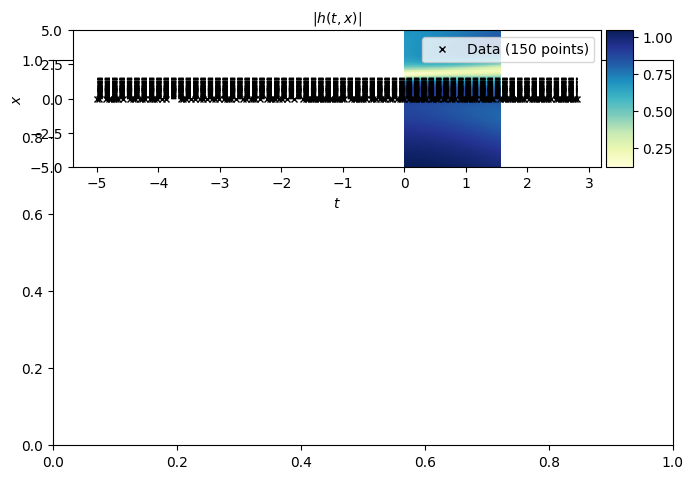

In [18]:
# Интерполяция данных для построения графиков
U_pred = griddata(X_star, u_pred.numpy().flatten(), (X, T), method='cubic')
V_pred = griddata(X_star, v_pred.numpy().flatten(), (X, T), method='cubic')
H_pred = griddata(X_star, h_pred.flatten(), (X, T), method='cubic')

# Визуализация результатов
fig, ax = plt.subplots(figsize=(8, 5))

# График амплитуды h(t,x)
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])
h = ax.imshow(H_pred.T, interpolation='none', cmap='YlGnBu',
              extent=[lb[1], ub[1], lb[0], ub[0]],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.plot(x0, np.zeros_like(x0), 'kx', label='Data (%d points)' % (x0.shape[0]), markersize=4, clip_on=False)

for t_val in tb.flatten():
    ax.plot([x.min(), x.max()], [t_val, t_val], 'k--', linewidth=1)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(loc='best')
ax.set_title('$|h(t,x)|$', fontsize=10)

# Графики срезов амплитуды h(t,x) в различные моменты времени
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

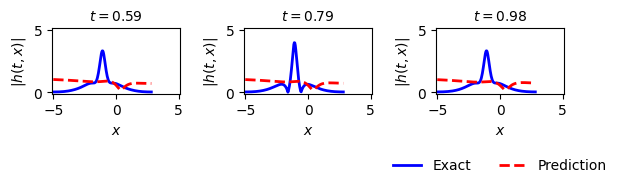

In [19]:
for i, t_index in enumerate([75, 100, 125]):
    ax = plt.subplot(gs1[0, i])

    # Интерполяция данных Exact_h[:, t_index] до размерности x
    y_interp = np.interp(x.flatten(), np.linspace(x.min(), x.max(), Exact_h[:, t_index].shape[0]), Exact_h[:, t_index])

    ax.plot(x.flatten(), y_interp, 'b-', linewidth=2, label='Exact')
    ax.plot(x.flatten(), H_pred[t_index, :], 'r--', linewidth=2, label='Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$|h(t,x)|$')

    # Используйте t[t_index][0], чтобы получить одиночное значение времени
    ax.set_title(f'$t = {t[t_index][0]:.2f}$', fontsize=10)
    
    ax.axis('square')
    ax.set_xlim([-5.1, 5.1])
    ax.set_ylim([-0.1, 5.1])
    if i == 2:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.8), ncol=5, frameon=False)
plt.show()  # Отображение графиков